In [2]:
# ~ ignore this cell, this is same as in final.ipynb ~

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

comments_df = pd.read_csv("../data/100m_steamreviews_helpfulonly.csv")
games_df = pd.read_csv("../data/steamgames71k.csv")

games_cols_to_keep = ['AppID', 'Name', 'Genres', 'Average playtime forever', 'Estimated owners', 'Supported languages']
games_dff = games_df[games_cols_to_keep]
comments_cols_to_keep = ['appid', 'language', 'voted_up', 'votes_up', 'votes_funny', 'received_for_free', 'author_num_reviews',
                         'game', 'review']
comments_dff = comments_df[comments_cols_to_keep]
comments_dff = comments_dff.rename(columns={'appid':'AppID', 'language':'reviewlanguage'})
combined_df = pd.merge(games_dff, comments_dff, on='AppID', how='inner')

# ~ ignore this cell, this is same as in final.ipynb ~

C:\Users\amons\AppData\Local\Temp\ipykernel_97276\2566868572.py:8: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv("../data/100m_steamreviews_helpfulonly.csv")


In [16]:
gns = set()
for gn in list(combined_df['Genres'].unique()):
    for g in str(gn).split(","):
        gns.add(g)
for g in sorted(list(gns)):
    print(g)

Accounting
Action
Adventure
Animation & Modeling
Audio Production
Casual
Design & Illustration
Early Access
Education
Free to Play
Game Development
Gore
Indie
Massively Multiplayer
Movie
Nudity
Photo Editing
RPG
Racing
Sexual Content
Simulation
Software Training
Sports
Strategy
Utilities
Video Production
Violent
Web Publishing
nan


In [ ]:
# ~ ~ ~ need to copy stuff below to final.ipynb ~ ~ ~

In [29]:
from collections import Counter
from wordcloud import WordCloud
from string import punctuation
import json

from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words("english"))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

import spacy
from spacy import displacy
spacynlp = spacy.load("en_core_web_sm")

In [28]:
# wordcloud helper functions

stopwords.update(["game", "games", "game,", "like", "get", "one", "time"])
stopwords.update(["i", "it", "we", "a couple", "weeks"])

def makewordcloud(wordcounter:Counter, title):
    wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(frequencies=dict(wordcounter))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def getwordcounts(reviewseries, stem=False):
    wordcounter = Counter()
    for reviewtext in reviewseries:
        txt = reviewtext.strip().lower()
        txt = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), txt))
        words = txt.split()
        words = [w for w in words if w not in stopwords]
        if stem:
            words = [stemmer.stem(w) for w in words]
        wordcounter.update(words)
    return wordcounter

generating wordcloud english no stem..


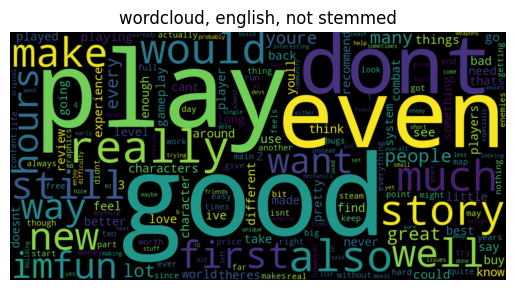

generating wordcloud english stem..


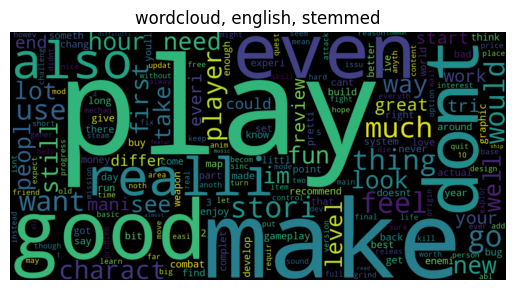

In [6]:
# wordcloud (english) (all genres)
# this takes like ~7 minutes to run

df = combined_df[["reviewlanguage", "review"]]
df = df.loc[df["reviewlanguage"] == "english"]

print("generating wordcloud english no stem..")
wordcounter = getwordcounts(df['review'], stem=False)
makewordcloud(wordcounter, "wordcloud, english, not stemmed")

print("generating wordcloud english stem..")
wordcounter = getwordcounts(df['review'], stem=True)
makewordcloud(wordcounter, "wordcloud, english, stemmed")

In [35]:
# wordcloud (english) (for each genre)
pass

In [ ]:
# noun phrase extraction (english) (all genres)
# this took like ~1.5 hours to run  T-T

nounchunk_counter = Counter()

df = combined_df[["reviewlanguage", "review"]]
df = df.loc[df["reviewlanguage"] == "english"]

for reviewtext in df["review"]:
    txt = reviewtext.strip().lower()
    
    doc = spacynlp(txt)
    for n in doc.noun_chunks:
        if n.text not in stopwords:
            nounchunk_counter[n.text] += 1

nounchunk_counter.most_common()
# write to file
with open("./nounphraseext_1.txt", "w") as f:
    f.write(str(nounchunk_counter.most_common()))

In [44]:
# noun phrase extraction (english) (for each genre)
# this is super slow T-T , idk how to make this faster

exp = "nce1"
genres_to_use = ["Indie", "Massively Multiplayer", "Free to Play", "RPG", "Adventure", "Casual", "Racing"]

# copy df
genres_df = combined_df[["Name", "reviewlanguage", "review", "Genres", "votes_up", "votes_funny"]].copy()
genres_df = genres_df.loc[genres_df["votes_funny"] <= 1000000]
genres_df = genres_df.loc[genres_df["reviewlanguage"] == "english"]
genres_df["votes_up_funny"] = genres_df["votes_up"] + genres_df["votes_funny"]
genres_df = genres_df.sort_values(["votes_up_funny"], ascending=False)

# one hot encoding for genres
genres_df['Genres'] = genres_df['Genres'].astype(str).str.split(',')
all_genres = set([genre for sublist in genres_df['Genres'] for genre in sublist if genre != 'nan'])
for genre in genres_to_use:
    genres_df[genre] = genres_df['Genres'].apply(lambda x: 1 if genre in x else 0)

# per genre calculations..
for genre in genres_to_use:
    print(f"\n\ncalculating for genre ~ {genre} ~ ...")
    df = genres_df.loc[genres_df[genre] == 1]
    df = df.head(1000)
    
    # noun chunk extraction
    gnc_counter = Counter()
    
    for reviewtext in df["review"]:
        txt = reviewtext.strip().lower()
        doc = spacynlp(txt)
        for n in doc.noun_chunks:
            # if n.text not in stopwords:
            gnc_counter[n.text] += 1
        
    # write to txt file
    with open(f"./wordcloudstuff/{exp}_{genre}.json", "w") as f:
        writedict = dict(gnc_counter.most_common())
        f.write(json.dumps(writedict))



calculating for genre ~ Indie ~ ...


calculating for genre ~ Massively Multiplayer ~ ...


calculating for genre ~ Free to Play ~ ...


calculating for genre ~ RPG ~ ...


calculating for genre ~ Adventure ~ ...


calculating for genre ~ Casual ~ ...


for genre ~ Indie ~ ...
[('us', 88), ('everyone', 85), ('time', 70), ('anything', 63), ('this review', 54), ('things', 53), ('anyone', 51), ('my head', 50), ('fun', 44), ('someone', 43), ('steam', 42), ('friends', 42), ('the end', 40), ('players', 39), ('games', 38), ('the devs', 38), ('the community', 34), ('food', 34), ('death', 34), ('the developers', 34), ('my life', 33), ('the way', 30), ('the fact', 29), ('sex', 28), ('[b] phone guy', 27), ('the world', 26), ('night', 26), ('bugs', 26), ('terraria', 26), ('hours', 26), ('the map', 25), ('this point', 25), ("garry's mod. wanna", 25), ('my friend', 24), ('money', 24), ('early access', 24), ('the story', 24), ('the player', 23), ('lots', 23), ('life', 22), ('the ground', 22), ('course', 21), ('hell', 21), ('edit', 21), ('fact', 20), ('resources', 20), ('enemies', 20), ('stardew valley', 19), ('rust', 19), ('none', 19), ('your friends', 19), ('the server', 19), ('a way', 18), ('the time', 18), ('fire', 18), ("garry's mod", 18), ('the

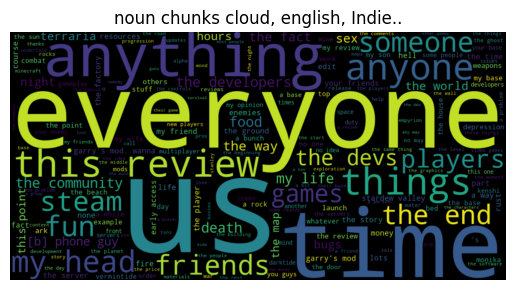

for genre ~ Massively Multiplayer ~ ...
[('us', 223), ('players', 208), ('time', 162), ('money', 145), ('anything', 135), ('the devs', 134), ('things', 134), ('everyone', 129), ('someone', 127), ('anyone', 102), ('this review', 100), ('steam', 99), ('hours', 96), ('the community', 95), ('the developers', 87), ('fun', 85), ('the time', 84), ('friends', 77), ('pvp', 77), ('ark', 70), ('the way', 70), ('the end', 68), ('the world', 65), ('the server', 63), ('content', 60), ('bugs', 60), ('the map', 59), ('games', 59), ('order', 56), ('new players', 50), ('the fact', 49), ('pubg', 49), ('others', 49), ('resources', 49), ('hundreds', 47), ('level', 45), ('other players', 43), ('rust', 43), ('my life', 42), ('servers', 42), ('items', 41), ('your character', 41), ('none', 41), ('my review', 40), ('this point', 39), ('course', 39), ('no one', 39), ('food', 38), ('part', 38), ("'s", 37), ('your money', 37), ('devs', 36), ('runescape', 36), ('your time', 35), ('edit', 35), ('the players', 34), (

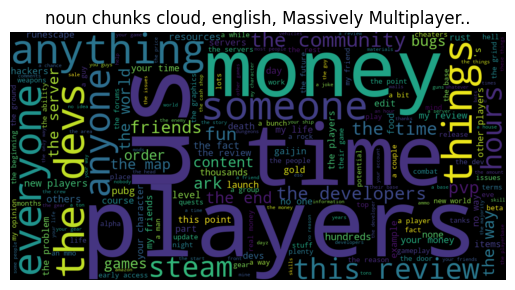

for genre ~ Free to Play ~ ...
[('someone', 146), ('time', 101), ('money', 96), ('us', 87), ('things', 83), ('players', 80), ('steam', 63), ('everyone', 62), ('anything', 61), ('my head', 61), ('this review', 58), ('weapons', 47), ('the time', 45), ('the community', 44), ('fun', 42), ('pubg', 42), ('friends', 41), ('anyone', 41), ('the devs', 40), ('your team', 38), ('games', 38), ('the developers', 35), ('warframe', 33), ('the end', 32), ('the way', 31), ('order', 31), ('content', 31), ('hours', 30), ('step', 30), ('the world', 29), ('my life', 29), ('lots', 28), ('pvp', 28), ('cheaters', 27), ('edit', 27), ("'s", 26), ('cs', 26), ('runescape', 26), ('gaijin', 25), ('the map', 25), ('hackers', 24), ('valve', 24), ('halo', 24), ('level', 24), ('others', 23), ('the fact', 23), ('a match', 22), ('gold', 22), ('tf2', 22), ('my friend', 22), ('destiny', 22), ('xp', 22), ('skins', 21), ('the point', 21), ('you guys', 21), ('none', 21), ('real money', 21), ('the dev', 21), ('monika', 20), ('

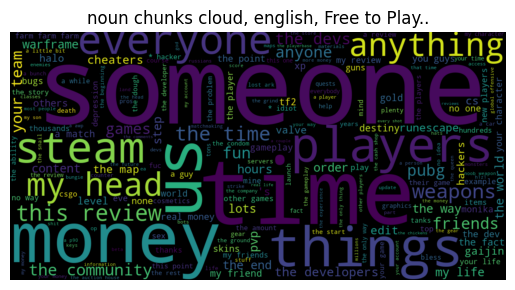

for genre ~ RPG ~ ...
[('mods', 160), ('time', 118), ('anything', 106), ('fallout', 103), ('us', 103), ('things', 101), ('everyone', 93), ('steam', 85), ('the world', 84), ('games', 82), ('players', 81), ('the end', 77), ('this review', 77), ('the story', 74), ('anyone', 71), ('fun', 63), ('the time', 63), ('someone', 63), ('hours', 58), ('money', 56), ('others', 53), ('the devs', 51), ('the fact', 51), ('the way', 50), ('bethesda', 48), ('content', 45), ('combat', 44), ('friends', 44), ('the developers', 44), ('enemies', 43), ('bugs', 41), ('edit', 41), ('your character', 41), ('order', 38), ('terraria', 38), ('weapons', 37), ('the map', 35), ('death', 34), ('the community', 33), ('the gameplay', 33), ('the player', 33), ("'s", 33), ('my son', 33), ('my opinion', 32), ('this point', 32), ('gra', 32), ('example', 31), ('quests', 31), ('pvp', 31), ('skyrim', 30), ('a bit', 30), ('the graphics', 29), ('my friend', 29), ('sex', 29), ('times', 28), ('stuff', 28), ('characters', 28), ('item

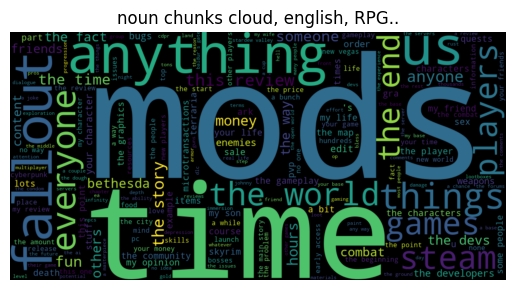

for genre ~ Adventure ~ ...
[('us', 105), ('anything', 95), ('things', 80), ('time', 77), ('everyone', 76), ('money', 69), ('players', 69), ('someone', 65), ('the developers', 65), ('games', 62), ('this review', 62), ('the devs', 59), ('steam', 56), ('anyone', 53), ('the end', 49), ('fun', 48), ('the story', 46), ('hours', 45), ('edit', 42), ('the way', 42), ('the time', 41), ('the world', 41), ('bugs', 39), ('launch', 38), ('the fact', 36), ('the map', 36), ('content', 33), ('enemies', 31), ('your money', 30), ('others', 29), ('early access', 28), ('the community', 28), ('food', 28), ('combat', 28), ('part', 27), ('my son', 27), ('my review', 26), ('pc', 26), ('top', 26), ('gameplay', 26), ('friends', 26), ('pvp', 26), ('the combat', 25), ('example', 25), ('order', 25), ('this point', 25), ('fact', 25), ('mind', 24), ('lots', 24), ('the people', 24), ('death', 24), ('terraria', 23), ('devs', 23), ('none', 23), ('your character', 22), ('resources', 22), ('stuff', 21), ('release', 21), 

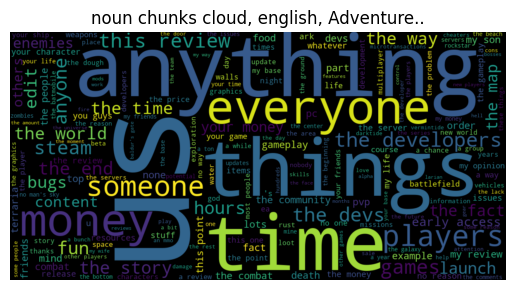

for genre ~ Casual ~ ...
[('the whole franchise', 188), ('my head', 127), ('sex', 66), ('us', 54), ('steam', 52), ('someone', 43), ('time', 39), ('everyone', 39), ('this review', 37), ('money', 36), ('battlefield', 32), ('my life', 31), ('anything', 30), ('friends', 30), ('lots', 28), ('things', 27), ('⠀⠀ ⢸', 27), ('fun', 26), ('the factory', 25), ('the end', 23), ('edit', 23), ('the dev', 23), ('games', 22), ('the time', 21), ('monika', 21), ('the story', 21), ('the world', 20), ('players', 19), ('anyone', 18), ('the developers', 18), ('⠧⢄', 17), ('life', 16), ('the community', 16), ('part', 16), ('the way', 16), ('⠀⠀⠀ ⢸', 16), ('the devs', 15), ('top', 15), ('launch', 15), ('u', 15), ('content', 15), ('hours', 14), ('the base game', 14), ('⢄⠀⠀⠀⠀ ⢸', 14), ('⠀⠀⢸ ⢸', 14), ('⠀⠀⢸', 14), ('my friends', 14), ('others', 14), ('no one', 13), ('the controls', 13), ('the rest', 13), ('⠑⠢⡄⠀ ⢸', 13), ('real life', 13), ('hank', 13), ('the map', 12), ('god', 12), ('gameplay', 12), ('the maps', 12)

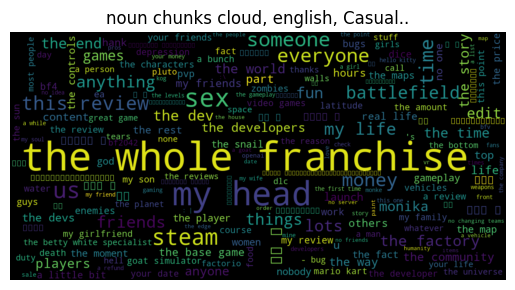

In [52]:
# continuation of above cell..
# noun phrase extraction (english) (for each genre) pt.2 ...

stopwords.update([" ", "game", "the game", "this game", "a game", "something", "everything", "nothing", "people", "a lot"])

genres_to_use = ["Indie", "Massively Multiplayer", "Free to Play", "RPG", "Adventure", "Casual"]

for genre in genres_to_use:
    with open(f"./wordcloudstuff/{exp}_{genre}.json", "r") as f:
        print(f"for genre ~ {genre} ~ ...")
        ncc = json.loads(f.read())
        ncc = Counter(ncc)
        
        nc:str
        for nc in list(ncc):
            if nc in stopwords:
                del ncc[nc]
            elif len(nc) == 1 and not nc.isalnum():
                del ncc[nc]
        
        print(ncc.most_common())
        
        makewordcloud(ncc, f"noun chunks cloud, english, {genre}..")